*Assignment made by Robert Dekkers (Anr. 545046)*

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First, download the dataset from the following link as .zip file:

https://academictorrents.com/details/7a638ed187a6180fd6e464b3666a6ea0499af4af

Then, extract the zip file into a folder. You can then upload this dataset to your google drive folder or use it on any platform you want.

For more information about dataset, you can see this article:
The Article: https://arxiv.org/abs/1912.12142


## Downloading and Saving Dataset

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Replace these paths with the actual paths to your dataset folders
data_dir = "/content/drive/MyDrive/DL_assignment/lung_colon_image_set"
filepaths = []
image_data = []
labels = []


folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath , f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path , file)
            try:
              # Open the image using PIL (or you can use OpenCV) within a 'with' statement
              with Image.open(fpath) as image:
                if image is not None:
                  # Resize images
                  im = image.resize((120,120), Image.LANCZOS)
                  # Append image and label to respective lists
                  image_data.append(np.array(im))
                else:
                  print(f"Error opening image '{fpath}': NoneType object returned")
            except Exception as e:
              print(f"Error opening image '{fpath}': {e}")
            # Assign the label of the images according to the folder they belongs to.
            if f == 'colon_aca':
                labels.append('Colon adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

tr_labels = np.array(labels)
image_matrix = np.array([np.array(img) for img in image_data])

# np.save("/content/drive/MyDrive/2. Deep Learning (880663-M-6)/Assignment/data120.npy",image_matrix)
# np.save("/content/drive/MyDrive/2. Deep Learning (880663-M-6)/Assignment/labels120.npy",tr_labels)
np.save("/content/drive/MyDrive/DL_assignment/data120.npy",image_matrix)
np.save("/content/drive/MyDrive/DL_assignment/labels120.npy",tr_labels)


Once you have saved the data and labels into a folder, you can call them from the related folder and use them in any way you want.

#Call data from directory

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# file_dir = "/content/drive/MyDrive/2. Deep Learning (880663-M-6)/Assignment/"
file_dir = "/content/drive/MyDrive/DL_assignment/"
data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)
print(labels)

['Colon adenocarcinoma' 'Colon adenocarcinoma' 'Colon adenocarcinoma' ...
 'Lung Squamous Cell Carcinoma' 'Lung Squamous Cell Carcinoma'
 'Lung Squamous Cell Carcinoma']


# Preprocessing and EDA (Exploratory Data Analysis)


## Converting the Target Values to the One-Hot-Encoded Format

In [21]:
from sklearn.preprocessing import OneHotEncoder

 # instantiate an Sklearn OneHotEncoder object with dense output
ohe = OneHotEncoder(sparse_output=False)

# Learn the data labels, and return the one-hot encoded data
# (we use .reshape(-1, 1) because Sklearn expects 2D-array format)
labels_ohe = ohe.fit_transform(labels.reshape(-1,1))

## Visualizing Sample Images

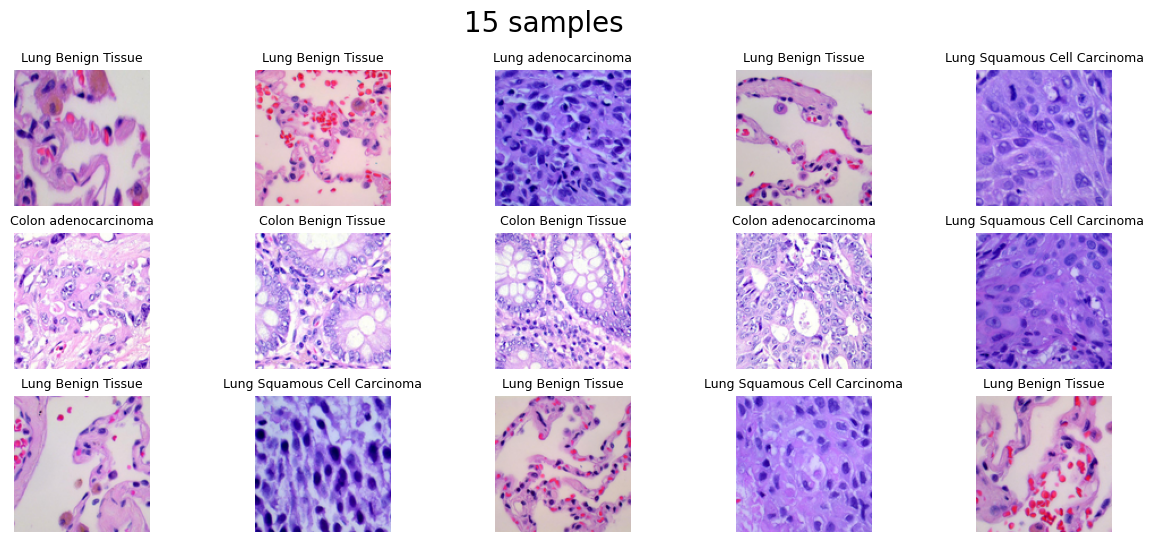

In [22]:
# Randomly select 15 indices from the dataset
sample_indices = np.random.choice(np.arange(len(data)), 15)

# Create a raster of 3 rows by 5 columns to display the sample images
fig, axes = plt.subplots(3,5, figsize=(15,6))
axes = axes.flatten()

# For each sample_index and diagram axes object...
for i, ax in zip(sample_indices, axes):
  ax.imshow(data[i])
  ax.set_title(labels[i], fontsize=9)
  ax.axis('off')
fig.suptitle("15 samples", fontsize=20)
plt.show()

## Visualizing Class Distribution

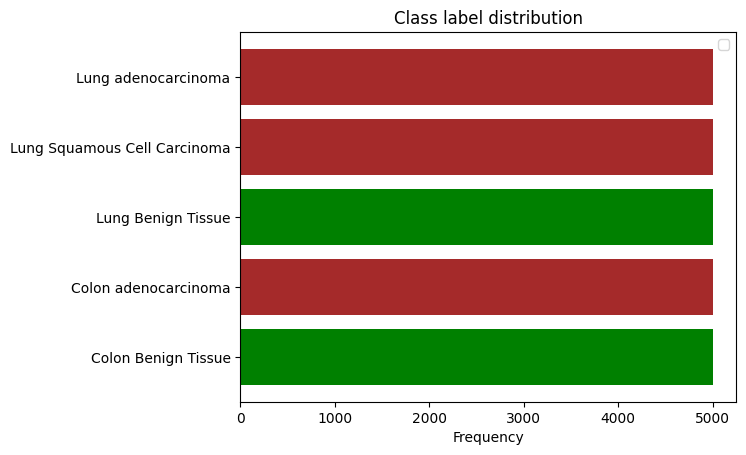

In [23]:
# Obtain the occurence count of each unique label in the dataset
distr = np.unique(labels, return_counts=True)

# Plot the occurence (distr[1]) of each label (distr[0])
plt.barh(y = distr[0], width = distr[1], color=['green', 'brown', 'green', 'brown', 'brown'])
plt.title('Class label distribution')
plt.legend()
plt.xlabel('Frequency')
plt.show()

##Train-Test-Val Split

In [24]:
from sklearn.model_selection import train_test_split

# Split dataset into training-, test- and validation sets in 2 steps
# We shuffle, because samples of the same label are next to each other

# Split the dataset into the subsets (training + validation) and (test)
X_trainval, X_test, y_trainval, y_test = train_test_split(data, labels_ohe, test_size = 0.2, shuffle = True, random_state = 42, stratify = labels_ohe)

# Split the (training + validation) set into a training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.25, shuffle = True, random_state = 42, stratify = y_trainval)

# Evaluation Functions

Since you will use the same evaluation functions several times ( to evaluate the baseline, enhanced and transfer learning models), it is better to prepare the standardized functions to calculate them each time in the same way.

In [34]:
## LOSS-ACC GRAPHS
def loss_acc_graphs(history):
  # Create a raster for displaying 2 diagrams next to each other
  fig, axes = plt.subplots(1,2, figsize=(10,5))

  # For each diagram, metric and corresponding title...
  for ax, metric, title in zip(axes, ['loss', 'categorical_accuracy'], ['Categorical Cross Entropy Loss', 'Categorical Accuracy']):
    # Plot the training- and validation values of the metric
    ax.plot(history.history[         metric], color = 'blue',   label = 'train')
    ax.plot(history.history['val_' + metric], color = 'orange', label = 'test')
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric.capitalize())
    ax.legend(['Training', 'Validation'], loc='right')

In [35]:
#Conf matrix and Classification Report:

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns

def conf_and_metrics(y_true, y_pred, set_name):

    # retrieve all labels in order, to reverse one-hot encoding
    uniq_labels = np.unique(labels)

    # undo one-hot encoding
    y_true_labels = [uniq_labels[i] for i in np.argmax(y_true, axis=1)]
    y_pred_labels = [uniq_labels[i] for i in np.argmax(y_pred, axis=1)]

    # display conf. matrix as heatmap, with corresponding labels per class
    plt.figure(figsize=(5,5))
    sns.heatmap(confusion_matrix(y_true_labels, y_pred_labels), annot = True, fmt="d",
                xticklabels = uniq_labels, yticklabels = uniq_labels)
    plt.title(f"{set_name} Confusion Matrix")
    plt.show()

    # display classif. report containing accuracy, precision, recall and F1
    print("Classification Report")
    print(classification_report(y_true_labels, y_pred_labels))

In [36]:
#ROC curves

from sklearn.metrics import roc_curve, auc, RocCurveDisplay

def auc_roc_graph(y_true, y_pred, set_name):

    plt.figure(figsize=(8,5))

    # Set up values to construct macro-average ROC over all classes
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tpr = np.zeros_like(fpr_grid)

    # retrieve all labels in order, to reverse one-hot encoding
    uniq_labels = np.unique(labels)

    # For every unique label, and every color
    for i in range(len(uniq_labels)):

        # Retrieve the false-positive rate and true-positive rate per threshold, for this class
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])

        # Plot the ROC-curve for this class, labeling the class including AUC value
        plt.plot(fpr, tpr, label=f"{i}: {uniq_labels[i]} (area={auc(fpr, tpr):.2f})")

        # Construct mean true-positive rate
        mean_tpr += np.interp(fpr_grid, fpr, tpr)

    # Calculate final mean true-positive rate
    mean_tpr /= len(uniq_labels)

    # Plot macro-average ROC of all classes
    plt.plot(fpr_grid, mean_tpr, label=f"Macro-average (area={auc(fpr_grid, mean_tpr):.2f})", linestyle="dashed")

    # Plot micro-average ROC of all classes
    fpr_micro, tpr_micro, _ = roc_curve(y_true.flatten(), y_pred.flatten())
    plt.plot(fpr_micro, tpr_micro, label=f"Micro-average (area={auc(fpr_micro, tpr_micro):.2f})", linestyle="dashed")

    # Plot ROC baseline diagonal
    plt.plot([0, 1], [0, 1], color="k", linestyle="dashed")

    plt.legend(loc='lower right')
    plt.title(f"{set_name} Receiver Operating Characteristics of Multi-class")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()


# Baseline Model

In [ ]:
import keras
from keras import layers

# Define the model

def build_model():

    # Instantiate sequential model
    model = keras.Sequential(
        [
            # Create input layer with input shape for 120*120 image with 3 color channels
            layers.Conv2D(filters = 128, kernel_size = 3, padding="same", activation = "relu", input_shape=(120,120,3)),
            layers.MaxPooling2D(pool_size = (2,2) ),
            layers.Conv2D(filters = 64, kernel_size = 3,  padding="same", activation = "relu"),
            layers.MaxPooling2D(pool_size = (2,2) ),
            layers.Flatten(),
            layers.Dense(units = 128, activation = "relu"),
            layers.Dense(units = 32, activation = "relu"),
            # Create output layer with one unit per prediction class
            layers.Dense(units = 5, activation = "softmax")
        ]
    )

    # Compile model with loss function and metric for multiclass classification
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

    return model

In [ ]:
model = build_model() # Instantiate the model
model.summary() # Show the characteristics of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

In [ ]:
# Fit model to training data, including validation data for evaluation
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, batch_size = 32)

Epoch 1/10
469/469 [==============================] - 28s 39ms/step - loss: 5.6198 - categorical_accuracy: 0.5656 - val_loss: 0.7256 - val_categorical_accuracy: 0.6452
Epoch 2/10
469/469 [==============================] - 15s 33ms/step - loss: 0.6208 - categorical_accuracy: 0.6981 - val_loss: 0.6110 - val_categorical_accuracy: 0.7174
Epoch 3/10
469/469 [==============================] - 15s 33ms/step - loss: 0.5648 - categorical_accuracy: 0.7233 - val_loss: 0.5663 - val_categorical_accuracy: 0.7374
Epoch 4/10
469/469 [==============================] - 16s 34ms/step - loss: 0.5313 - categorical_accuracy: 0.7476 - val_loss: 0.6745 - val_categorical_accuracy: 0.7260
Epoch 5/10
469/469 [==============================] - 17s 35ms/step - loss: 0.4827 - categorical_accuracy: 0.7749 - val_loss: 0.6610 - val_categorical_accuracy: 0.7112
Epoch 6/10
469/469 [==============================] - 15s 33ms/step - loss: 0.4462 - categorical_accuracy: 0.7901 - val_loss: 0.5911 - val_categorical_accuracy:

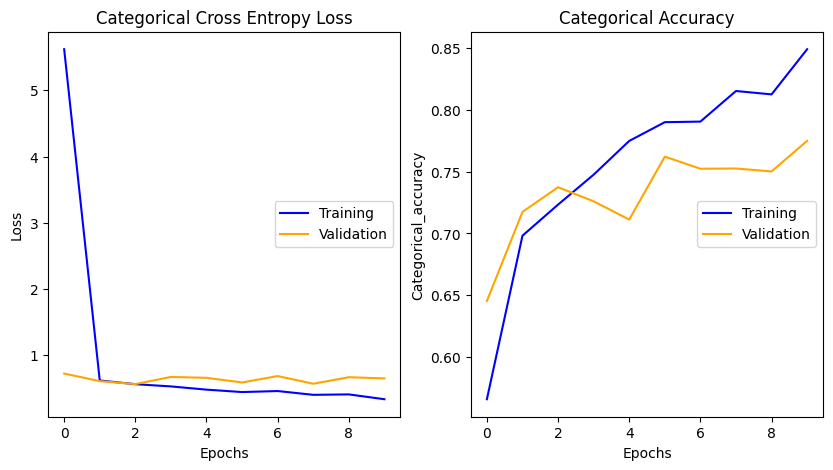

In [ ]:
# Display loss- and accuracy graphs
loss_acc_graphs(history)

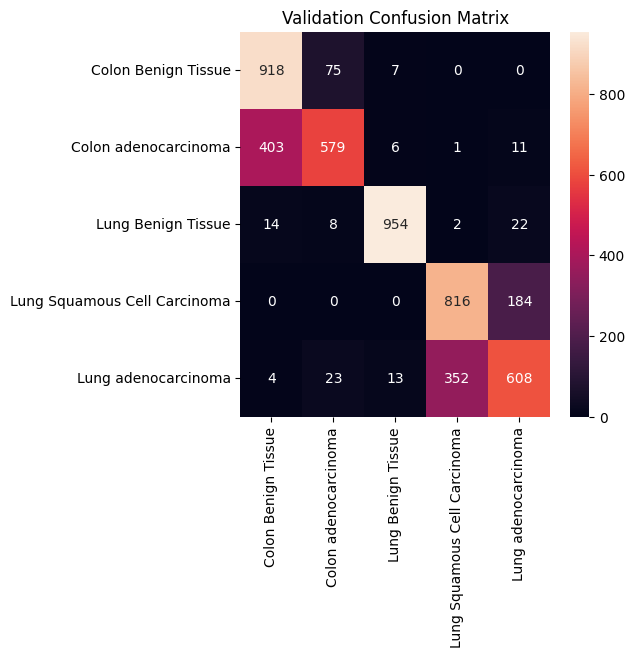

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.69      0.92      0.78      1000
        Colon adenocarcinoma       0.85      0.58      0.69      1000
          Lung Benign Tissue       0.97      0.95      0.96      1000
Lung Squamous Cell Carcinoma       0.70      0.82      0.75      1000
         Lung adenocarcinoma       0.74      0.61      0.67      1000

                    accuracy                           0.78      5000
                   macro avg       0.79      0.77      0.77      5000
                weighted avg       0.79      0.78      0.77      5000



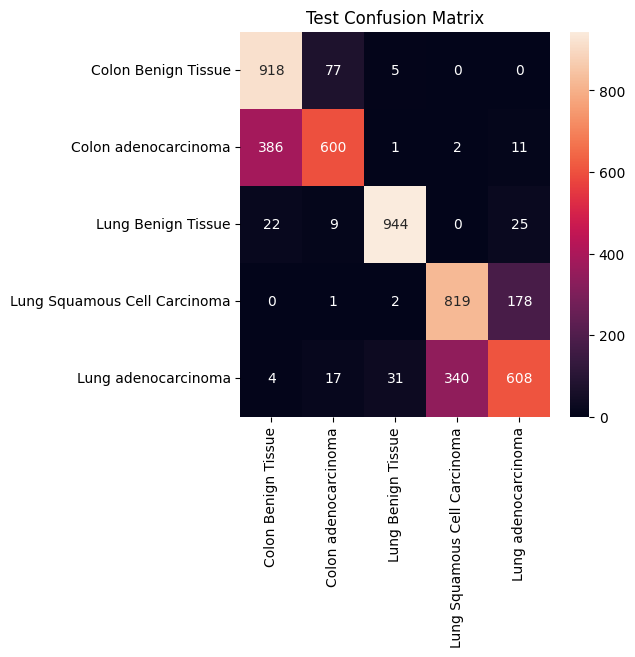

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.69      0.92      0.79      1000
        Colon adenocarcinoma       0.85      0.60      0.70      1000
          Lung Benign Tissue       0.96      0.94      0.95      1000
Lung Squamous Cell Carcinoma       0.71      0.82      0.76      1000
         Lung adenocarcinoma       0.74      0.61      0.67      1000

                    accuracy                           0.78      5000
                   macro avg       0.79      0.78      0.77      5000
                weighted avg       0.79      0.78      0.77      5000



In [ ]:
# Display confidence matrix and various metrics, for validation set and test set
conf_and_metrics(y_val, model.predict(X_val, verbose=0), "Validation")
conf_and_metrics(y_test, model.predict(X_test, verbose=0), "Test")

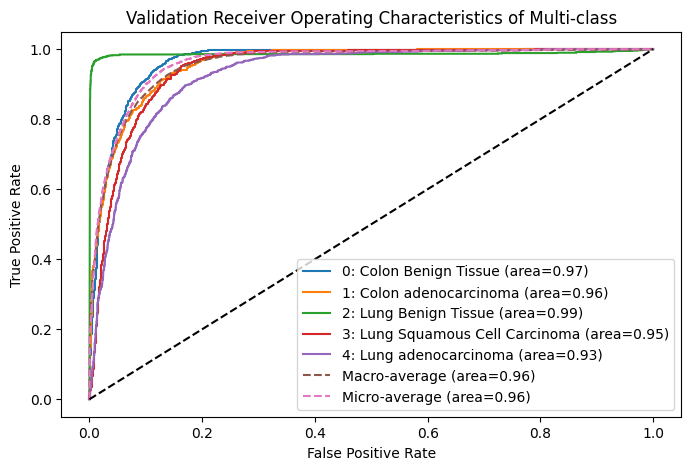

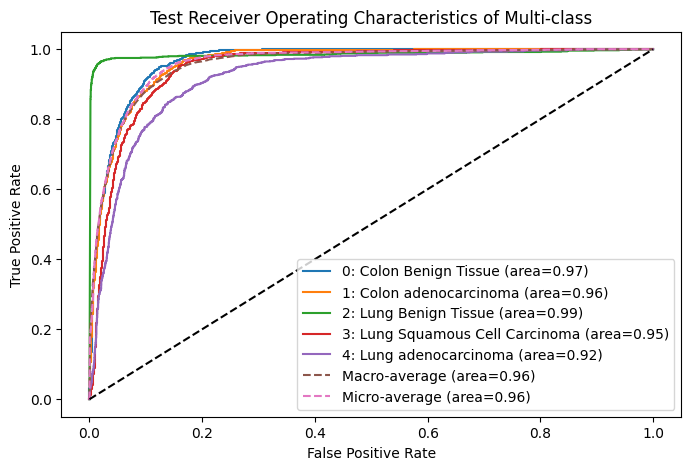

In [ ]:
# Display ROC-curves and AUC-scores for validation set and test set
auc_roc_graph(y_val, model.predict(X_val, verbose=0), "Validation")
auc_roc_graph(y_test, model.predict(X_test, verbose=0), "Test")

# Enhanced Model

## Experiment 1: Increase convolution filters in second layer

##### Model definition

In [ ]:
import keras
from keras import layers

# Define the model

def build_model():

    # Instantiate sequential model
    model = keras.Sequential(
        [
            # Create input layer with input shape for 120*120 image with 3 color channels
            layers.Conv2D(filters = 128, kernel_size = 3, padding="same", activation = "relu", input_shape=(120,120,3)),
            layers.MaxPooling2D(pool_size = (2,2) ),
            layers.Conv2D(filters = 256, kernel_size = 3,  padding="same", activation = "relu"), # CHANGE: 'filters' increased from 64 to 256
            layers.MaxPooling2D(pool_size = (2,2) ),
            layers.Flatten(),
            layers.Dense(units = 128, activation = "relu"),
            layers.Dense(units = 32, activation = "relu"),
            # Create output layer with one unit per prediction class
            layers.Dense(units = 5, activation = "softmax")
        ]
    )

    # Compile model with loss function and metric for multiclass classification
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

    return model

##### Model training

In [ ]:
model = build_model()
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, batch_size = 32)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 256)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 230400)            0         
                                                                 
 dense_3 (Dense)             (None, 128)              

##### Model evaluation


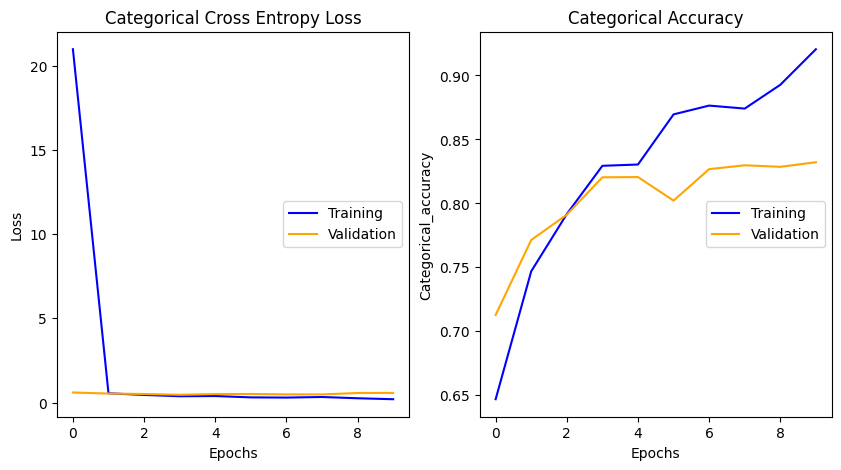

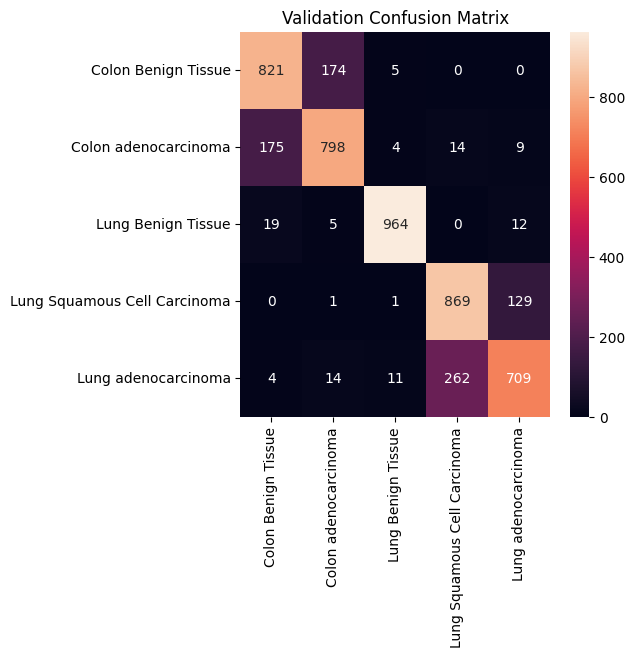

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.81      0.82      0.81      1000
        Colon adenocarcinoma       0.80      0.80      0.80      1000
          Lung Benign Tissue       0.98      0.96      0.97      1000
Lung Squamous Cell Carcinoma       0.76      0.87      0.81      1000
         Lung adenocarcinoma       0.83      0.71      0.76      1000

                    accuracy                           0.83      5000
                   macro avg       0.83      0.83      0.83      5000
                weighted avg       0.83      0.83      0.83      5000



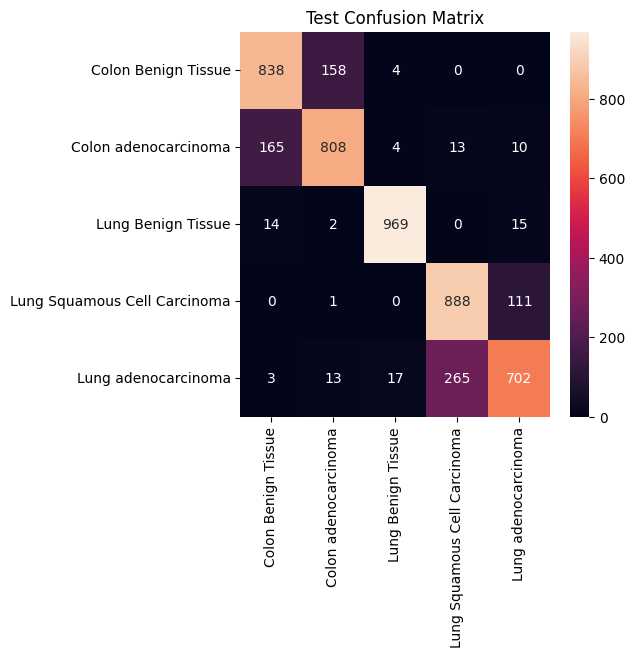

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.82      0.84      0.83      1000
        Colon adenocarcinoma       0.82      0.81      0.82      1000
          Lung Benign Tissue       0.97      0.97      0.97      1000
Lung Squamous Cell Carcinoma       0.76      0.89      0.82      1000
         Lung adenocarcinoma       0.84      0.70      0.76      1000

                    accuracy                           0.84      5000
                   macro avg       0.84      0.84      0.84      5000
                weighted avg       0.84      0.84      0.84      5000



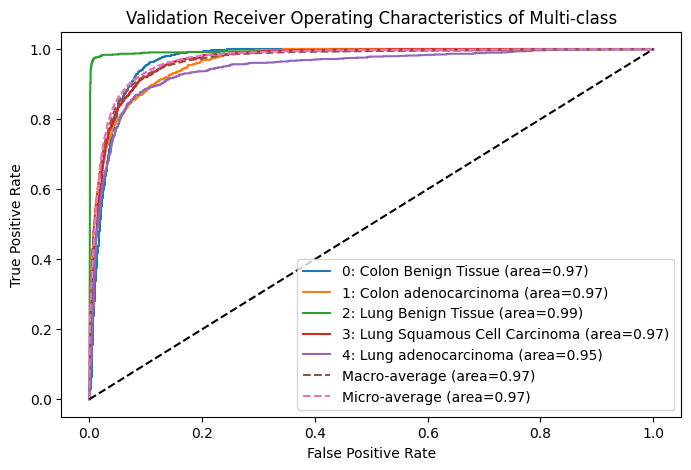

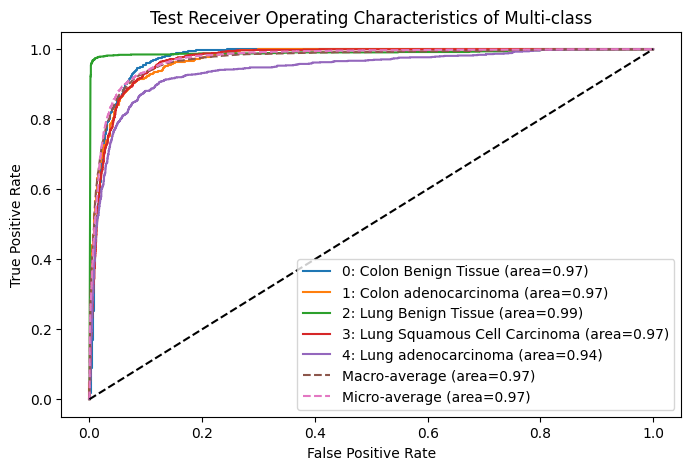

In [ ]:
loss_acc_graphs(history)
conf_and_metrics(y_val, model.predict(X_val, verbose=0), "Validation")
conf_and_metrics(y_test, model.predict(X_test, verbose=0), "Test")
auc_roc_graph(y_val, model.predict(X_val, verbose=0), "Validation")
auc_roc_graph(y_test, model.predict(X_test, verbose=0), "Test")

## Experiment 2

##### Model definition

In [ ]:
import keras
from keras import layers

# Define the model

def build_model():

    # Instantiate sequential model
    model = keras.Sequential(
        [
            # Create input layer with input shape for 120*120 image with 3 color channels
            layers.Conv2D(filters = 128, kernel_size = 3, padding="same", activation = "relu", input_shape=(120,120,3)),
            layers.MaxPooling2D(pool_size = (2,2) ),
            layers.Conv2D(filters = 256, kernel_size = 3,  padding="same", activation = "relu"),
            layers.MaxPooling2D(pool_size = (2,2) ),
            layers.Conv2D(filters = 512, kernel_size = 3,  padding="same", activation = "relu"),   # CHANGE: layer added
            layers.MaxPooling2D(pool_size = (2,2) ),  # CHANGE: layer added
            layers.Flatten(),
            layers.Dense(units = 128, activation = "relu"),
            layers.Dense(units = 32, activation = "relu"),
            # Create output layer with one unit per prediction class
            layers.Dense(units = 5, activation = "softmax")
        ]
    )

    # Compile model with loss function and metric for multiclass classification
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

    return model

##### Model training

In [ ]:
model = build_model()
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, batch_size = 32)

Epoch 1/10
469/469 [==============================] - 43s 83ms/step - loss: 4.6245 - categorical_accuracy: 0.6872 - val_loss: 0.5337 - val_categorical_accuracy: 0.6738
Epoch 2/10
469/469 [==============================] - 40s 85ms/step - loss: 0.4270 - categorical_accuracy: 0.8152 - val_loss: 0.4995 - val_categorical_accuracy: 0.7750
Epoch 3/10
469/469 [==============================] - 37s 80ms/step - loss: 0.3454 - categorical_accuracy: 0.8540 - val_loss: 0.2524 - val_categorical_accuracy: 0.8888
Epoch 4/10
469/469 [==============================] - 37s 79ms/step - loss: 0.2256 - categorical_accuracy: 0.9130 - val_loss: 0.2457 - val_categorical_accuracy: 0.9068
Epoch 5/10
469/469 [==============================] - 35s 74ms/step - loss: 0.2319 - categorical_accuracy: 0.9097 - val_loss: 0.2325 - val_categorical_accuracy: 0.9066
Epoch 6/10
469/469 [==============================] - 35s 74ms/step - loss: 0.1722 - categorical_accuracy: 0.9354 - val_loss: 0.1965 - val_categorical_accuracy:

##### Model evaluation


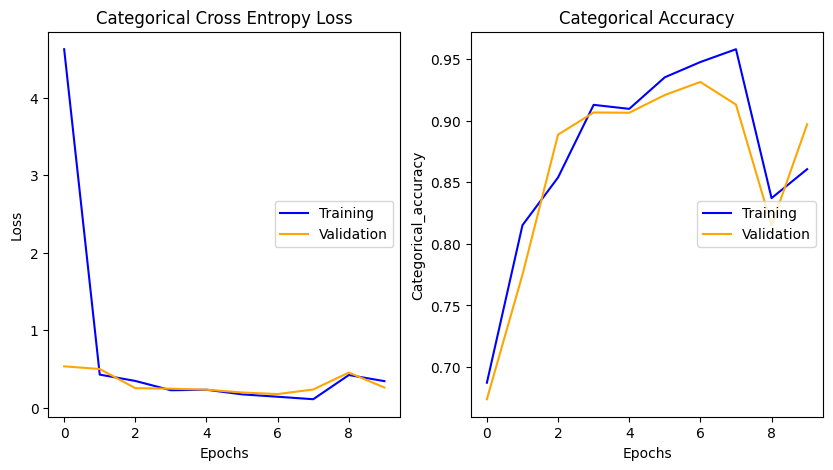

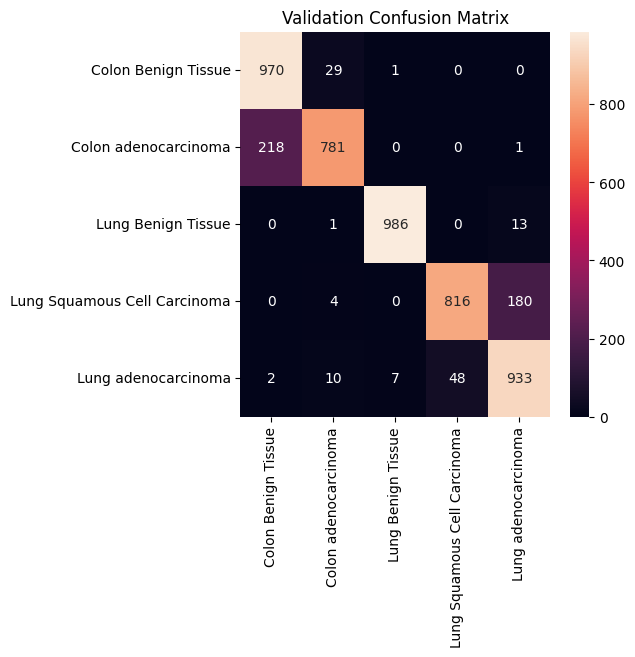

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.82      0.97      0.89      1000
        Colon adenocarcinoma       0.95      0.78      0.86      1000
          Lung Benign Tissue       0.99      0.99      0.99      1000
Lung Squamous Cell Carcinoma       0.94      0.82      0.88      1000
         Lung adenocarcinoma       0.83      0.93      0.88      1000

                    accuracy                           0.90      5000
                   macro avg       0.91      0.90      0.90      5000
                weighted avg       0.91      0.90      0.90      5000



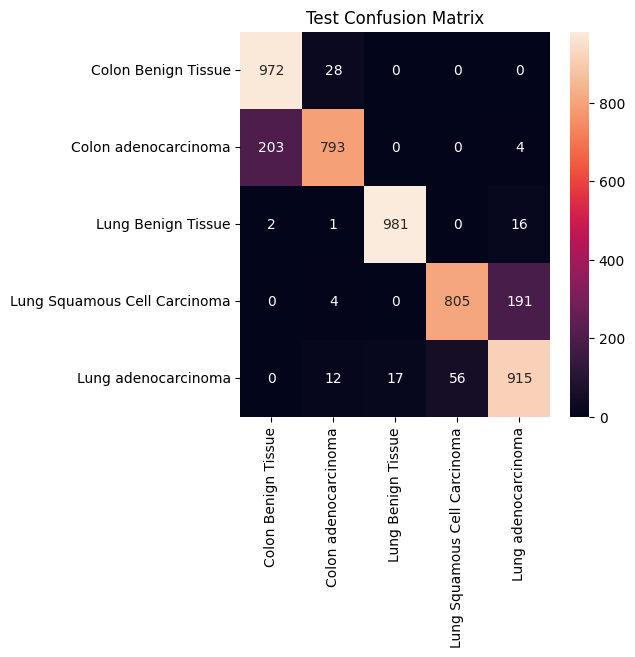

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.83      0.97      0.89      1000
        Colon adenocarcinoma       0.95      0.79      0.86      1000
          Lung Benign Tissue       0.98      0.98      0.98      1000
Lung Squamous Cell Carcinoma       0.93      0.81      0.87      1000
         Lung adenocarcinoma       0.81      0.92      0.86      1000

                    accuracy                           0.89      5000
                   macro avg       0.90      0.89      0.89      5000
                weighted avg       0.90      0.89      0.89      5000



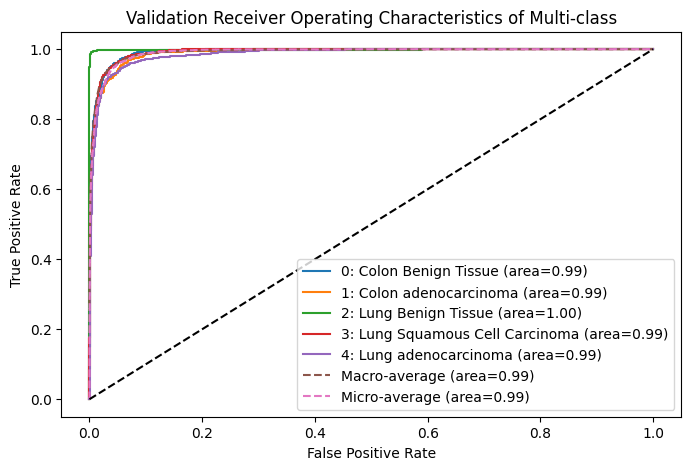

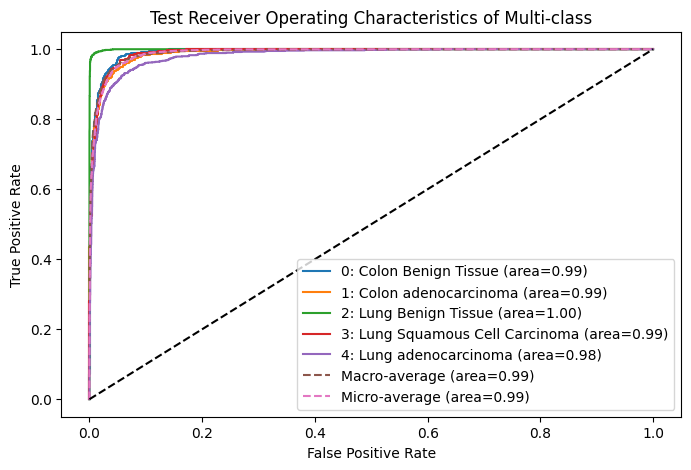

In [ ]:
loss_acc_graphs(history)
conf_and_metrics(y_val, model.predict(X_val, verbose=0), "Validation")
conf_and_metrics(y_test, model.predict(X_test, verbose=0), "Test")
auc_roc_graph(y_val, model.predict(X_val, verbose=0), "Validation")
auc_roc_graph(y_test, model.predict(X_test, verbose=0), "Test")

## Experiment 3

##### Model definition

In [ ]:
import keras
from keras import layers

# Define the model

def build_model():

    # Instantiate sequential model
    model = keras.Sequential(
        [
            # Create input layer with input shape for 120*120 image with 3 color channels
            layers.Conv2D(filters = 128, strides = (2,2), kernel_size = 3, padding="same", activation = "relu", input_shape=(120,120,3)), # CHANGE: 'strides' of (2,2)
            layers.MaxPooling2D(pool_size = (2,2) ),
            layers.Conv2D(filters = 256, strides = (2,2), kernel_size = 3,  padding="same", activation = "relu"),  # CHANGE: 'strides' of (2,2)
            layers.MaxPooling2D(pool_size = (2,2) ),
            layers.Conv2D(filters = 512, strides = (2,2), kernel_size = 3,  padding="same", activation = "relu"),  # CHANGE: 'strides' of (2,2)
            layers.MaxPooling2D(pool_size = (2,2) ),
            layers.Flatten(),
            layers.Dense(units = 128, activation = "relu"),
            layers.Dense(units = 32, activation = "relu"),
            # Create output layer with one unit per prediction class
            layers.Dense(units = 5, activation = "softmax")
        ]
    )

    # Compile model with loss function and metric for multiclass classification
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

    return model

##### Model training

In [ ]:
model = build_model()
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, batch_size = 32)

Epoch 1/10
469/469 [==============================] - 12s 19ms/step - loss: 1.6656 - categorical_accuracy: 0.7489 - val_loss: 0.2845 - val_categorical_accuracy: 0.8904
Epoch 2/10
469/469 [==============================] - 9s 20ms/step - loss: 0.3140 - categorical_accuracy: 0.8679 - val_loss: 0.2966 - val_categorical_accuracy: 0.8718
Epoch 3/10
469/469 [==============================] - 7s 15ms/step - loss: 0.2485 - categorical_accuracy: 0.8985 - val_loss: 0.2802 - val_categorical_accuracy: 0.8876
Epoch 4/10
469/469 [==============================] - 7s 16ms/step - loss: 0.1858 - categorical_accuracy: 0.9250 - val_loss: 0.3308 - val_categorical_accuracy: 0.8746
Epoch 5/10
469/469 [==============================] - 8s 17ms/step - loss: 0.1834 - categorical_accuracy: 0.9303 - val_loss: 0.2399 - val_categorical_accuracy: 0.9090
Epoch 6/10
469/469 [==============================] - 7s 15ms/step - loss: 0.1382 - categorical_accuracy: 0.9454 - val_loss: 0.1228 - val_categorical_accuracy: 0.95

##### Model evaluation


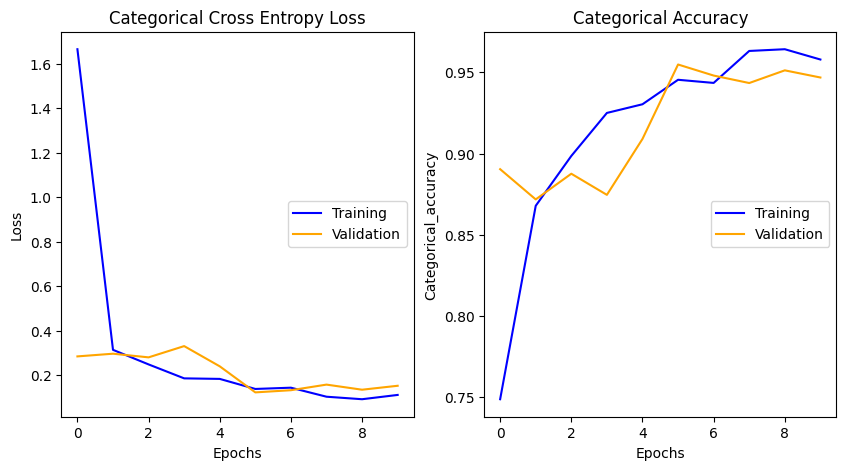

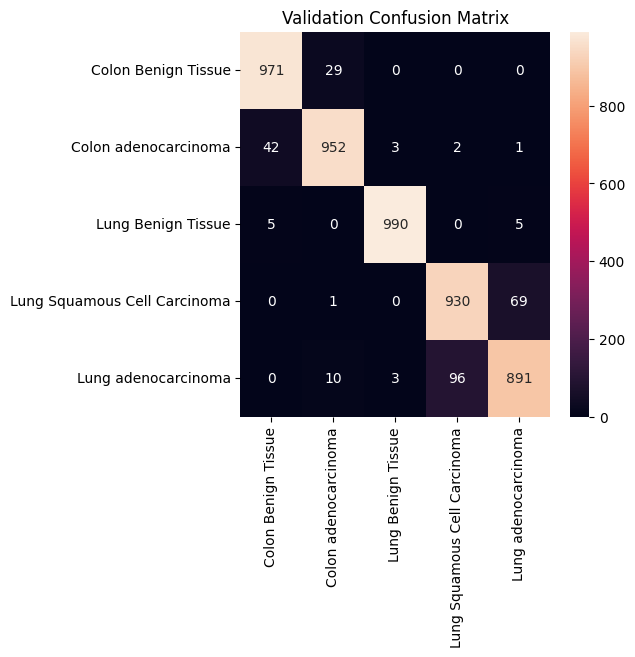

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.95      0.97      0.96      1000
        Colon adenocarcinoma       0.96      0.95      0.96      1000
          Lung Benign Tissue       0.99      0.99      0.99      1000
Lung Squamous Cell Carcinoma       0.90      0.93      0.92      1000
         Lung adenocarcinoma       0.92      0.89      0.91      1000

                    accuracy                           0.95      5000
                   macro avg       0.95      0.95      0.95      5000
                weighted avg       0.95      0.95      0.95      5000



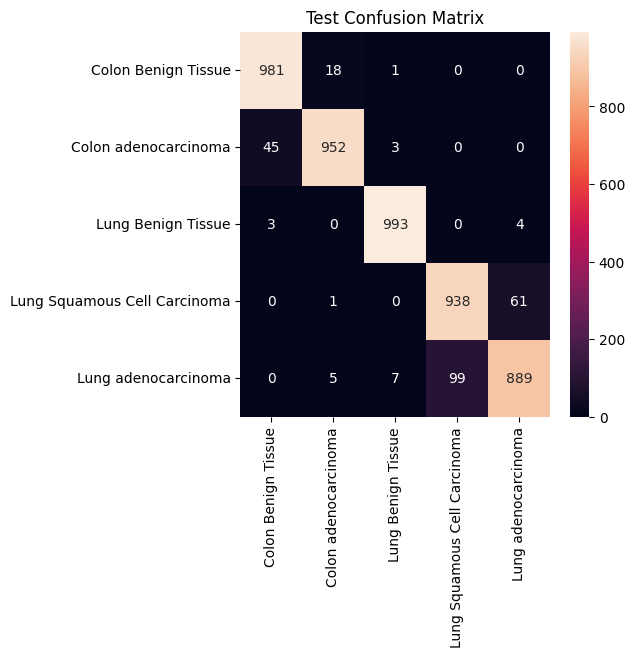

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.95      0.98      0.97      1000
        Colon adenocarcinoma       0.98      0.95      0.96      1000
          Lung Benign Tissue       0.99      0.99      0.99      1000
Lung Squamous Cell Carcinoma       0.90      0.94      0.92      1000
         Lung adenocarcinoma       0.93      0.89      0.91      1000

                    accuracy                           0.95      5000
                   macro avg       0.95      0.95      0.95      5000
                weighted avg       0.95      0.95      0.95      5000



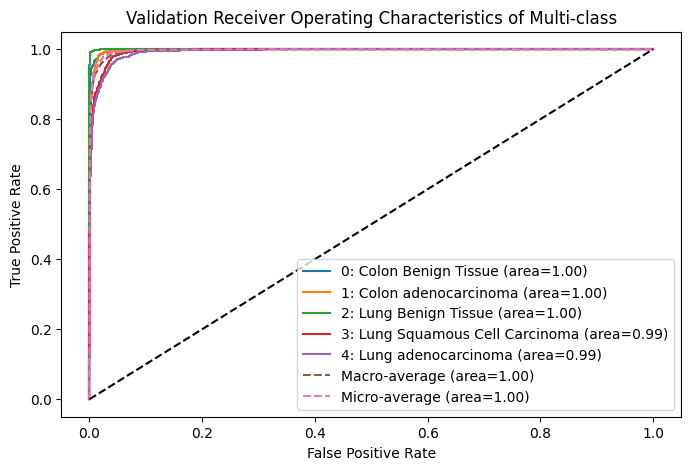

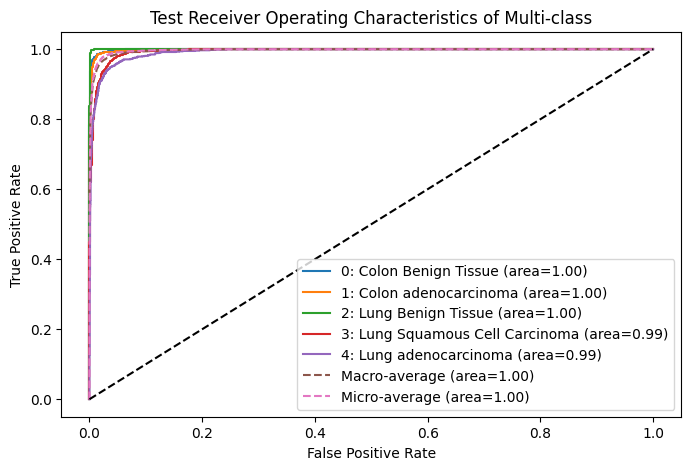

In [ ]:
loss_acc_graphs(history)
conf_and_metrics(y_val, model.predict(X_val, verbose=0), "Validation")
conf_and_metrics(y_test, model.predict(X_test, verbose=0), "Test")
auc_roc_graph(y_val, model.predict(X_val, verbose=0), "Validation")
auc_roc_graph(y_test, model.predict(X_test, verbose=0), "Test")

## Experiment 4

##### Model definition

In [ ]:
import keras
from keras import layers

# Define the model

def build_model():

    # Instantiate sequential model
    model = keras.Sequential(
        [
            # Create input layer with input shape for 120*120 image with 3 color channels
            layers.Conv2D(filters = 128, strides = (2,2), kernel_size = 3, padding="same", activation = "relu", input_shape=(120,120,3)),
            layers.AveragePooling2D(pool_size = (2,2) ), # CHANGE: max pooling layer replaced by average pooling layer
            layers.Conv2D(filters = 256, strides = (2,2), kernel_size = 3,  padding="same", activation = "relu"),
            layers.AveragePooling2D(pool_size = (2,2) ), # CHANGE: max pooling layer replaced by average pooling layer
            layers.Conv2D(filters = 512, strides = (2,2), kernel_size = 3,  padding="same", activation = "relu"),
            layers.AveragePooling2D(pool_size = (2,2) ), # CHANGE: max pooling layer replaced by average pooling layer
            layers.Flatten(),
            layers.Dense(units = 128, activation = "relu"),
            layers.Dense(units = 32, activation = "relu"),
            # Create output layer with one unit per prediction class
            layers.Dense(units = 5, activation = "softmax")
        ]
    )

    # Compile model with loss function and metric for multiclass classification
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

    return model

##### Model training

In [ ]:
model = build_model()
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, batch_size = 32)

Epoch 1/10
469/469 [==============================] - 9s 16ms/step - loss: 0.9613 - categorical_accuracy: 0.6627 - val_loss: 0.6755 - val_categorical_accuracy: 0.7102
Epoch 2/10
469/469 [==============================] - 8s 17ms/step - loss: 0.5192 - categorical_accuracy: 0.7833 - val_loss: 0.4817 - val_categorical_accuracy: 0.7512
Epoch 3/10
469/469 [==============================] - 8s 16ms/step - loss: 0.4195 - categorical_accuracy: 0.8271 - val_loss: 0.3601 - val_categorical_accuracy: 0.8664
Epoch 4/10
469/469 [==============================] - 7s 15ms/step - loss: 0.3302 - categorical_accuracy: 0.8669 - val_loss: 0.3032 - val_categorical_accuracy: 0.8882
Epoch 5/10
469/469 [==============================] - 7s 15ms/step - loss: 0.2751 - categorical_accuracy: 0.8891 - val_loss: 0.2162 - val_categorical_accuracy: 0.9140
Epoch 6/10
469/469 [==============================] - 8s 16ms/step - loss: 0.2157 - categorical_accuracy: 0.9127 - val_loss: 0.1913 - val_categorical_accuracy: 0.916

##### Model evaluation


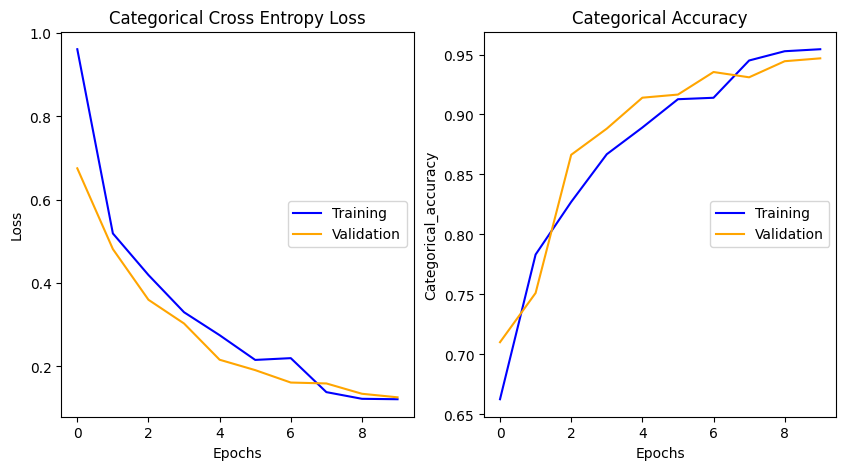

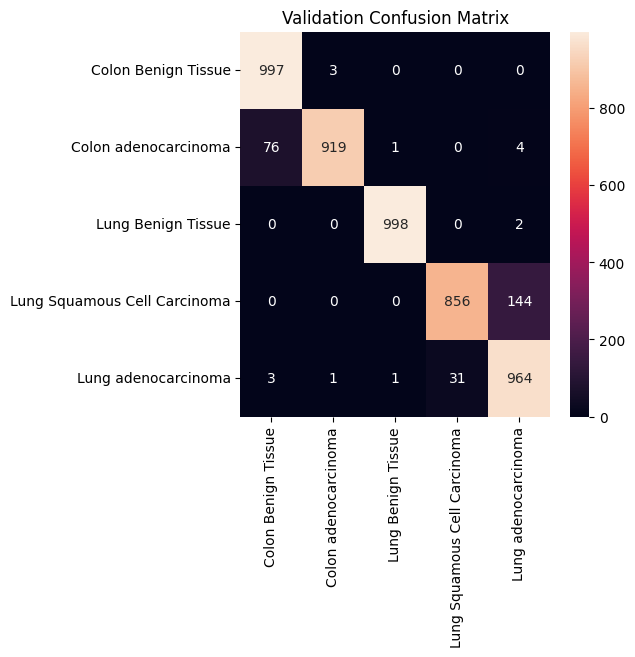

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.93      1.00      0.96      1000
        Colon adenocarcinoma       1.00      0.92      0.96      1000
          Lung Benign Tissue       1.00      1.00      1.00      1000
Lung Squamous Cell Carcinoma       0.97      0.86      0.91      1000
         Lung adenocarcinoma       0.87      0.96      0.91      1000

                    accuracy                           0.95      5000
                   macro avg       0.95      0.95      0.95      5000
                weighted avg       0.95      0.95      0.95      5000



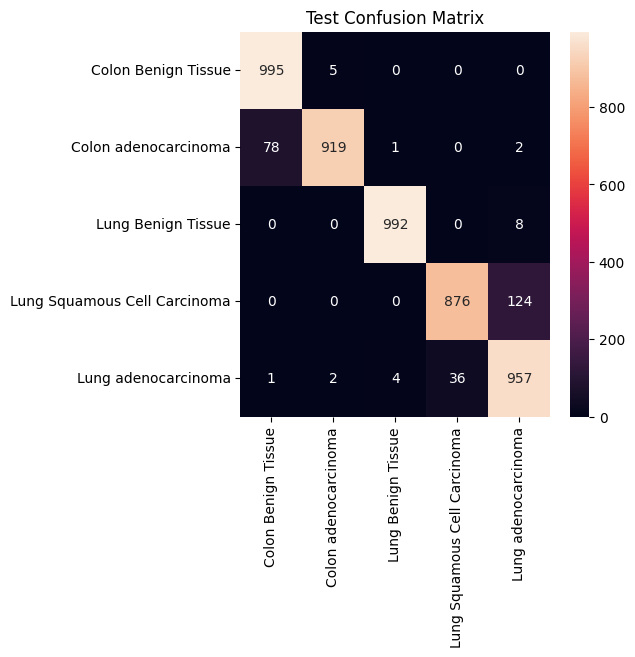

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.93      0.99      0.96      1000
        Colon adenocarcinoma       0.99      0.92      0.95      1000
          Lung Benign Tissue       0.99      0.99      0.99      1000
Lung Squamous Cell Carcinoma       0.96      0.88      0.92      1000
         Lung adenocarcinoma       0.88      0.96      0.92      1000

                    accuracy                           0.95      5000
                   macro avg       0.95      0.95      0.95      5000
                weighted avg       0.95      0.95      0.95      5000



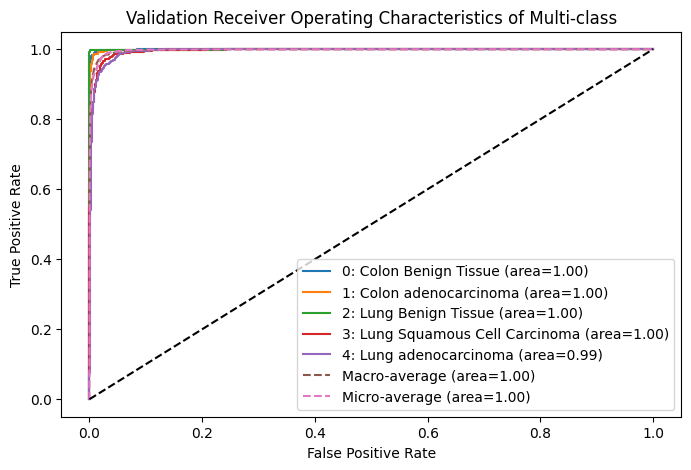

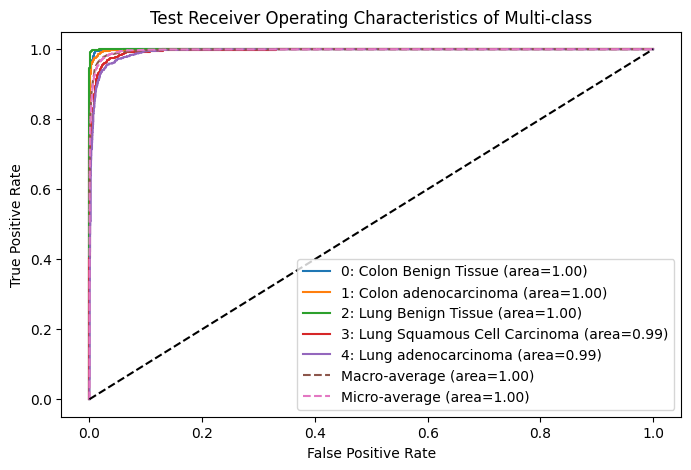

In [ ]:
loss_acc_graphs(history)
conf_and_metrics(y_val, model.predict(X_val, verbose=0), "Validation")
conf_and_metrics(y_test, model.predict(X_test, verbose=0), "Test")
auc_roc_graph(y_val, model.predict(X_val, verbose=0), "Validation")
auc_roc_graph(y_test, model.predict(X_test, verbose=0), "Test")

## Experiment 5

##### Model definition

In [13]:
import keras
from keras import layers

# Define the model

def build_model():

    # Instantiate sequential model
    model = keras.Sequential(
        [
            # Create input layer with input shape for 120*120 image with 3 color channels
            layers.Conv2D(filters = 128, strides = (2,2), kernel_size = 3, padding="same", activation = "relu", input_shape=(120,120,3)),
            layers.AveragePooling2D(pool_size = (2,2) ),
            layers.Conv2D(filters = 256, strides = (2,2), kernel_size = 3,  padding="same", activation = "relu"),
            layers.AveragePooling2D(pool_size = (2,2) ),
            layers.Conv2D(filters = 512, strides = (2,2), kernel_size = 3,  padding="same", activation = "relu"),
            layers.AveragePooling2D(pool_size = (2,2) ),
            layers.Flatten(),
            layers.Dense(units = 128, activation = "relu"),
            layers.Dense(units = 32, activation = "relu"),
            # Create output layer with one unit per prediction class
            layers.Dense(units = 5, activation = "softmax")
        ]
    )

    # Compile model with loss function and metric for multiclass classification
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

    return model

##### Model training

In [14]:
model = build_model()
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 15, batch_size = 32) # CHANGE: epochs increased to 15

Epoch 1/15
469/469 [==============================] - 11s 20ms/step - loss: 1.1443 - categorical_accuracy: 0.6717 - val_loss: 0.5563 - val_categorical_accuracy: 0.7586
Epoch 2/15
469/469 [==============================] - 8s 16ms/step - loss: 0.5421 - categorical_accuracy: 0.7687 - val_loss: 0.4527 - val_categorical_accuracy: 0.8102
Epoch 3/15
469/469 [==============================] - 8s 18ms/step - loss: 0.4367 - categorical_accuracy: 0.8143 - val_loss: 0.4340 - val_categorical_accuracy: 0.8284
Epoch 4/15
469/469 [==============================] - 7s 16ms/step - loss: 0.3766 - categorical_accuracy: 0.8425 - val_loss: 0.3309 - val_categorical_accuracy: 0.8770
Epoch 5/15
469/469 [==============================] - 8s 16ms/step - loss: 0.3227 - categorical_accuracy: 0.8691 - val_loss: 0.2783 - val_categorical_accuracy: 0.8906
Epoch 6/15
469/469 [==============================] - 7s 15ms/step - loss: 0.2476 - categorical_accuracy: 0.9015 - val_loss: 0.2094 - val_categorical_accuracy: 0.91

##### Model evaluation


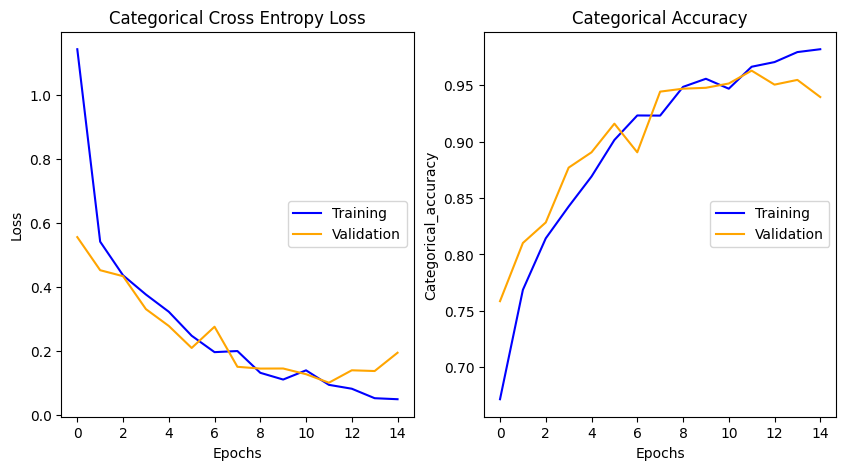

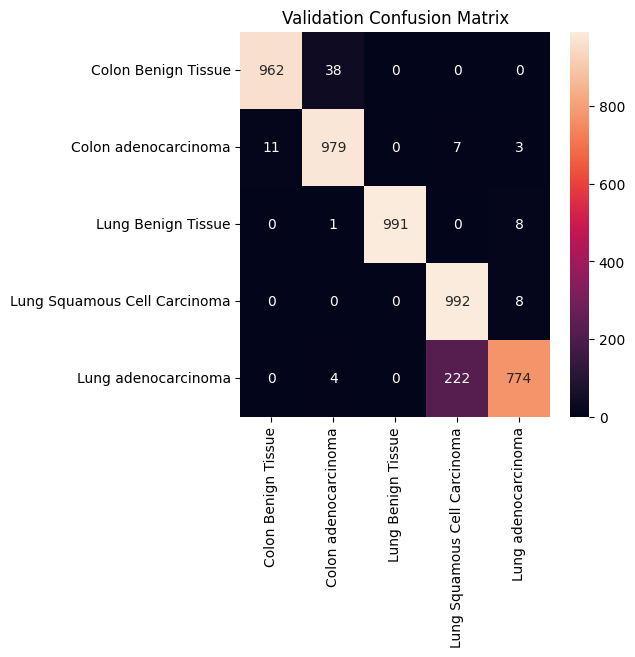

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.99      0.96      0.98      1000
        Colon adenocarcinoma       0.96      0.98      0.97      1000
          Lung Benign Tissue       1.00      0.99      1.00      1000
Lung Squamous Cell Carcinoma       0.81      0.99      0.89      1000
         Lung adenocarcinoma       0.98      0.77      0.86      1000

                    accuracy                           0.94      5000
                   macro avg       0.95      0.94      0.94      5000
                weighted avg       0.95      0.94      0.94      5000



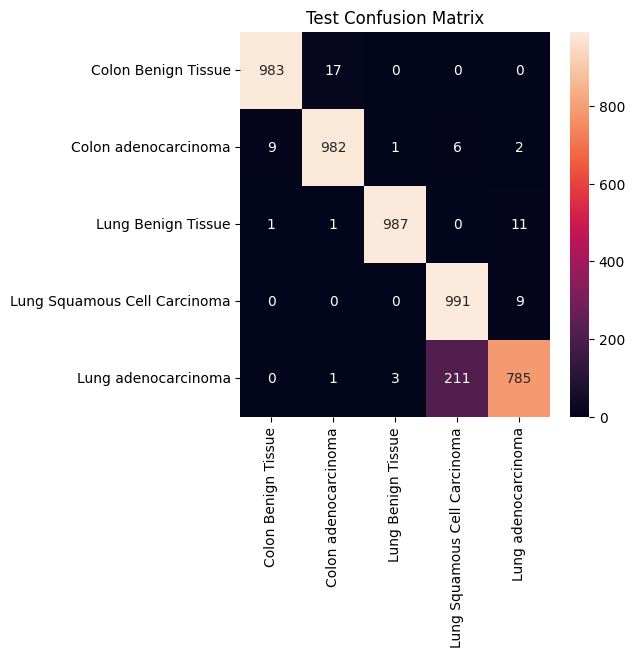

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.99      0.98      0.99      1000
        Colon adenocarcinoma       0.98      0.98      0.98      1000
          Lung Benign Tissue       1.00      0.99      0.99      1000
Lung Squamous Cell Carcinoma       0.82      0.99      0.90      1000
         Lung adenocarcinoma       0.97      0.79      0.87      1000

                    accuracy                           0.95      5000
                   macro avg       0.95      0.95      0.95      5000
                weighted avg       0.95      0.95      0.95      5000



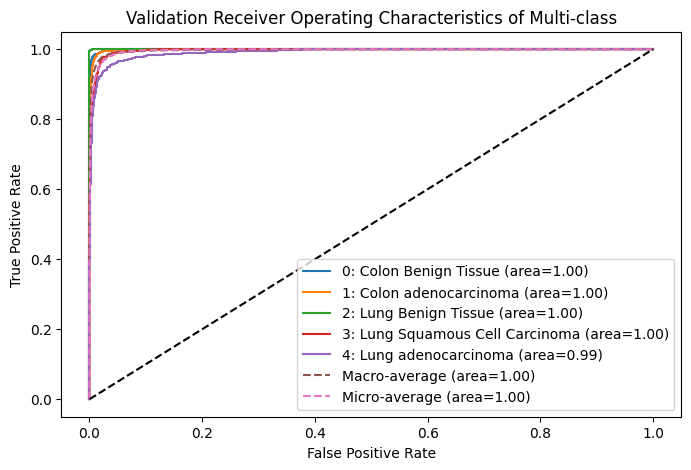

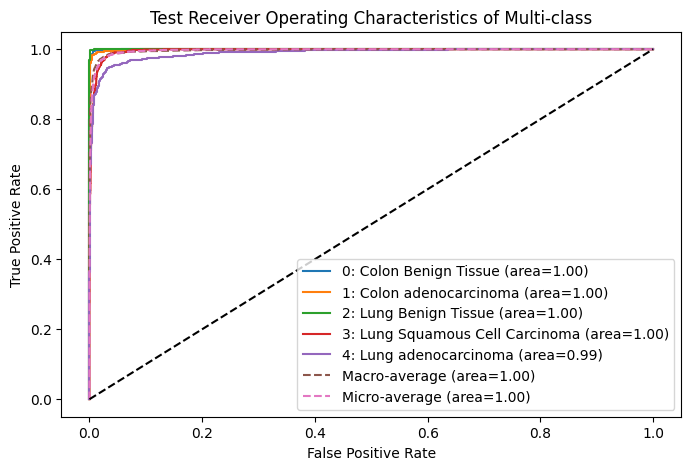

In [15]:
loss_acc_graphs(history)
conf_and_metrics(y_val, model.predict(X_val, verbose=0), "Validation")
conf_and_metrics(y_test, model.predict(X_test, verbose=0), "Test")
auc_roc_graph(y_val, model.predict(X_val, verbose=0), "Validation")
auc_roc_graph(y_test, model.predict(X_test, verbose=0), "Test")

## Experiment 6

##### Model definition

In [16]:
import keras
from keras import layers

# Define the model

def build_model():

    # Instantiate sequential model
    model = keras.Sequential(
        [
            # Create input layer with input shape for 120*120 image with 3 color channels
            layers.Conv2D(filters = 128, strides = (2,2), kernel_size = 3, padding="same", activation = "relu", input_shape=(120,120,3)),
            layers.AveragePooling2D(pool_size = (2,2) ),
            layers.Conv2D(filters = 256, strides = (2,2), kernel_size = 3,  padding="same", activation = "relu"),
            layers.AveragePooling2D(pool_size = (2,2) ),
            layers.Conv2D(filters = 512, strides = (2,2), kernel_size = 3,  padding="same", activation = "relu"),
            layers.AveragePooling2D(pool_size = (2,2) ),
            layers.Flatten(),
            layers.Dense(units = 128, activation = "relu"),
            layers.Dropout(0.2),  # CHANGE: dropout layer added
            layers.Dense(units = 32, activation = "relu"),
            layers.Dropout(0.2),  # CHANGE: dropout layer added
            # Create output layer with one unit per prediction class
            layers.Dense(units = 5, activation = "softmax")
        ]
    )

    # Compile model with loss function and metric for multiclass classification
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

    return model

##### Model training

In [17]:
model = build_model()
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 15, batch_size = 32)

Epoch 1/15
469/469 [==============================] - 11s 18ms/step - loss: 1.3556 - categorical_accuracy: 0.4693 - val_loss: 0.6394 - val_categorical_accuracy: 0.6708
Epoch 2/15
469/469 [==============================] - 8s 16ms/step - loss: 0.6465 - categorical_accuracy: 0.6929 - val_loss: 0.5178 - val_categorical_accuracy: 0.7834
Epoch 3/15
469/469 [==============================] - 8s 17ms/step - loss: 0.5624 - categorical_accuracy: 0.7421 - val_loss: 0.5422 - val_categorical_accuracy: 0.7580
Epoch 4/15
469/469 [==============================] - 8s 16ms/step - loss: 0.4835 - categorical_accuracy: 0.7825 - val_loss: 0.4276 - val_categorical_accuracy: 0.8206
Epoch 5/15
469/469 [==============================] - 9s 19ms/step - loss: 0.4119 - categorical_accuracy: 0.8256 - val_loss: 0.3055 - val_categorical_accuracy: 0.8696
Epoch 6/15
469/469 [==============================] - 7s 15ms/step - loss: 0.3346 - categorical_accuracy: 0.8653 - val_loss: 0.2684 - val_categorical_accuracy: 0.89

##### Model evaluation


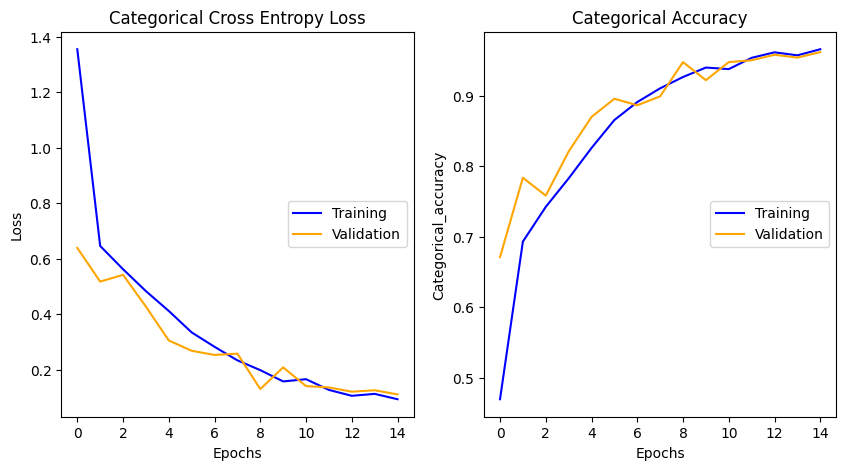

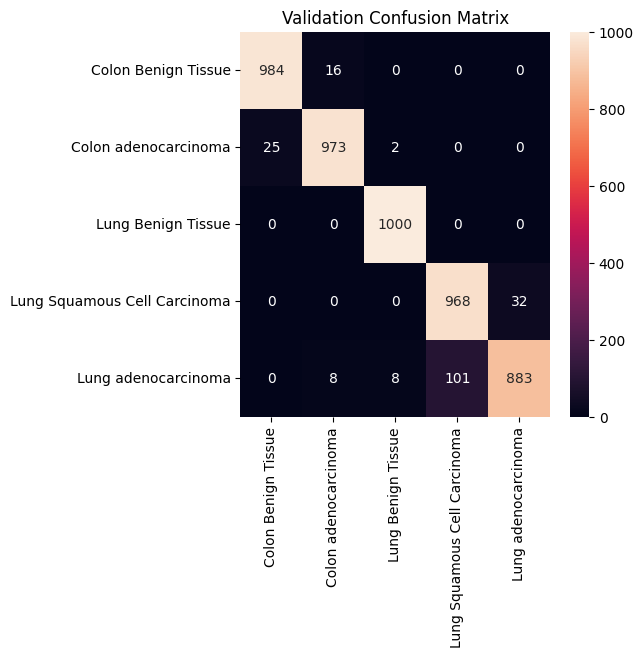

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.98      0.98      0.98      1000
        Colon adenocarcinoma       0.98      0.97      0.97      1000
          Lung Benign Tissue       0.99      1.00      1.00      1000
Lung Squamous Cell Carcinoma       0.91      0.97      0.94      1000
         Lung adenocarcinoma       0.97      0.88      0.92      1000

                    accuracy                           0.96      5000
                   macro avg       0.96      0.96      0.96      5000
                weighted avg       0.96      0.96      0.96      5000



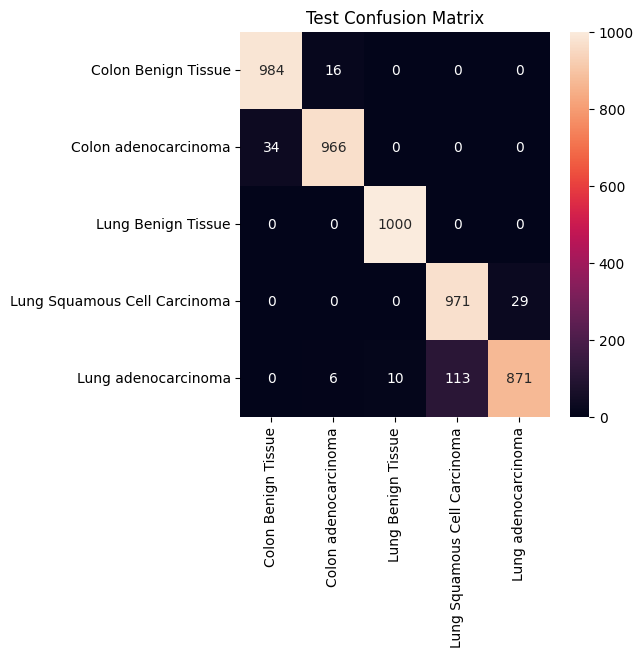

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.97      0.98      0.98      1000
        Colon adenocarcinoma       0.98      0.97      0.97      1000
          Lung Benign Tissue       0.99      1.00      1.00      1000
Lung Squamous Cell Carcinoma       0.90      0.97      0.93      1000
         Lung adenocarcinoma       0.97      0.87      0.92      1000

                    accuracy                           0.96      5000
                   macro avg       0.96      0.96      0.96      5000
                weighted avg       0.96      0.96      0.96      5000



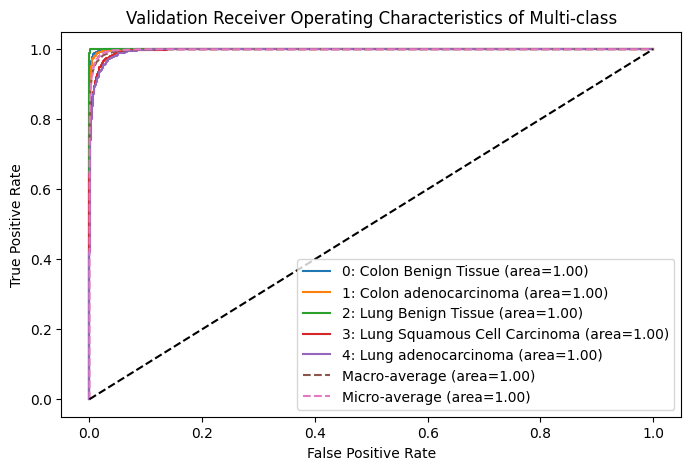

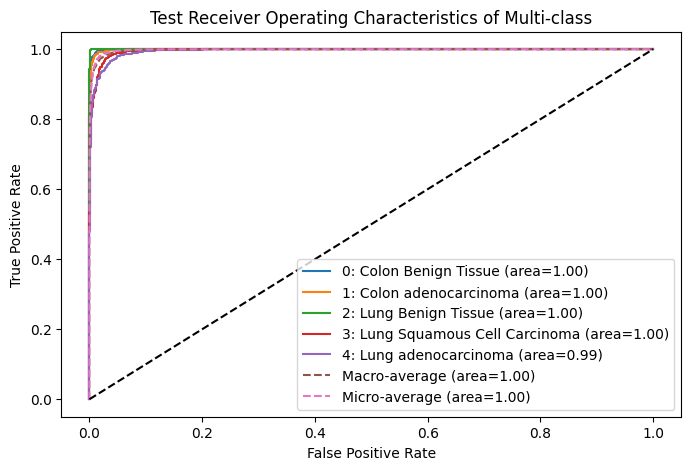

In [18]:
loss_acc_graphs(history)
conf_and_metrics(y_val, model.predict(X_val, verbose=0), "Validation")
conf_and_metrics(y_test, model.predict(X_test, verbose=0), "Test")
auc_roc_graph(y_val, model.predict(X_val, verbose=0), "Validation")
auc_roc_graph(y_test, model.predict(X_test, verbose=0), "Test")

# Transfer Learning Model


##### Model definition

In [41]:
import keras
from keras import layers
from keras.applications.densenet import DenseNet121
from keras.models import Model

def build_densenet121():

  model = DenseNet121(include_top=False, input_shape=(120,120,3)) # Load model without output layer

  # Make DenseNet121-layers un-trainable
  for layer in model.layers:
    layer.trainable = False

  # Create (trainable) fully-connected layers at end of model
  flat1 = layers.Flatten()(model.layers[-1].output)
  dense1 = layers.Dense(128, activation = "relu")(flat1)
  dense2 = layers.Dense(32, activation = "relu")(dense1)
  output = layers.Dense(5, activation = "softmax")(dense2)

  model = Model(inputs = model.inputs, outputs = output)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

  return model

##### Model training

In [42]:
# Instantiate and fit model
model = build_densenet121()
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, batch_size = 32)

Epoch 1/10
469/469 [==============================] - 41s 67ms/step - loss: 1.2474 - categorical_accuracy: 0.6261 - val_loss: 0.7598 - val_categorical_accuracy: 0.7534
Epoch 2/10
469/469 [==============================] - 20s 44ms/step - loss: 0.4666 - categorical_accuracy: 0.8428 - val_loss: 0.4153 - val_categorical_accuracy: 0.8830
Epoch 3/10
469/469 [==============================] - 21s 45ms/step - loss: 0.3629 - categorical_accuracy: 0.8651 - val_loss: 0.4514 - val_categorical_accuracy: 0.8618
Epoch 4/10
469/469 [==============================] - 21s 44ms/step - loss: 0.2848 - categorical_accuracy: 0.8949 - val_loss: 0.3531 - val_categorical_accuracy: 0.8780
Epoch 5/10
469/469 [==============================] - 21s 44ms/step - loss: 0.2684 - categorical_accuracy: 0.8995 - val_loss: 0.2471 - val_categorical_accuracy: 0.9050
Epoch 6/10
469/469 [==============================] - 20s 44ms/step - loss: 0.2379 - categorical_accuracy: 0.9097 - val_loss: 0.2369 - val_categorical_accuracy:

##### Model evaluation

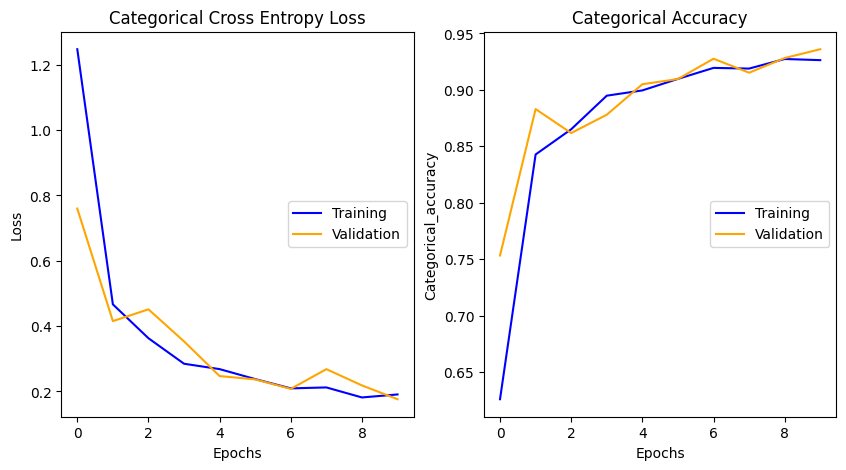

In [43]:
loss_acc_graphs(history)

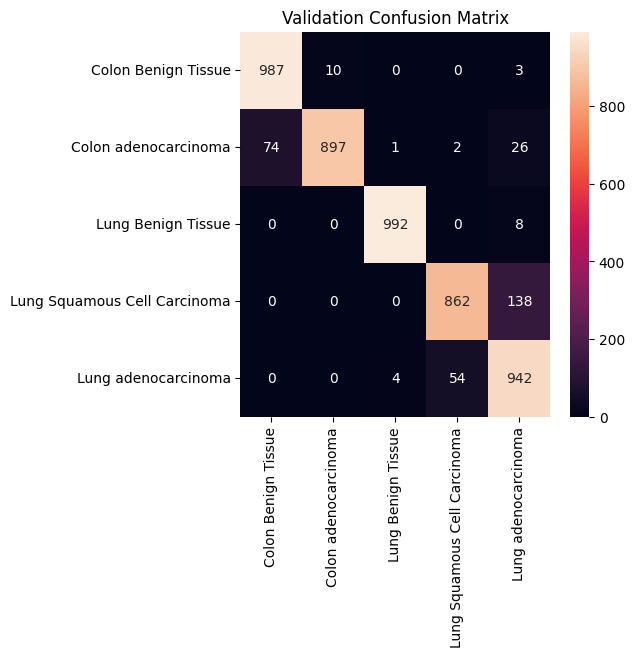

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.93      0.99      0.96      1000
        Colon adenocarcinoma       0.99      0.90      0.94      1000
          Lung Benign Tissue       0.99      0.99      0.99      1000
Lung Squamous Cell Carcinoma       0.94      0.86      0.90      1000
         Lung adenocarcinoma       0.84      0.94      0.89      1000

                    accuracy                           0.94      5000
                   macro avg       0.94      0.94      0.94      5000
                weighted avg       0.94      0.94      0.94      5000



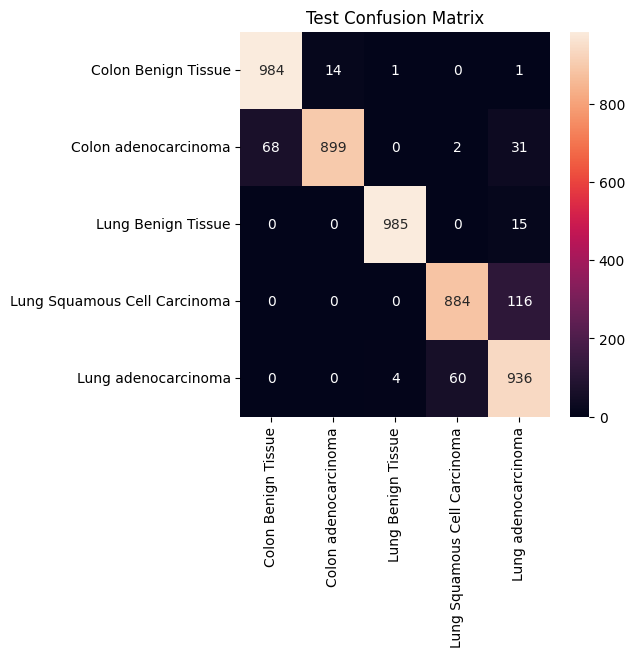

Classification Report
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.94      0.98      0.96      1000
        Colon adenocarcinoma       0.98      0.90      0.94      1000
          Lung Benign Tissue       0.99      0.98      0.99      1000
Lung Squamous Cell Carcinoma       0.93      0.88      0.91      1000
         Lung adenocarcinoma       0.85      0.94      0.89      1000

                    accuracy                           0.94      5000
                   macro avg       0.94      0.94      0.94      5000
                weighted avg       0.94      0.94      0.94      5000



In [44]:
conf_and_metrics(y_val, model.predict(X_val, verbose=0), "Validation")
conf_and_metrics(y_test, model.predict(X_test, verbose=0), "Test")

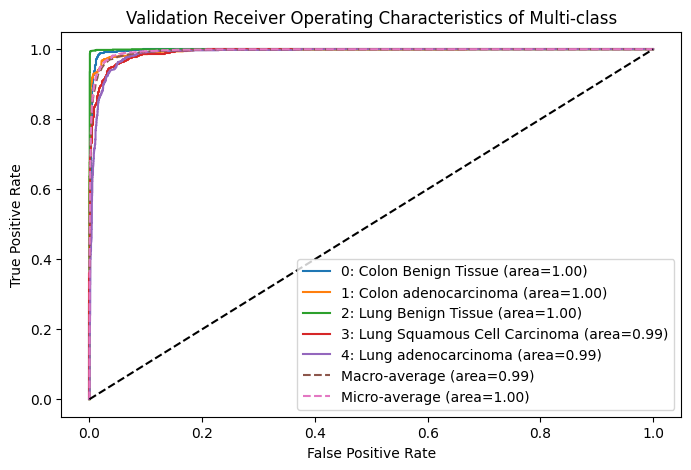

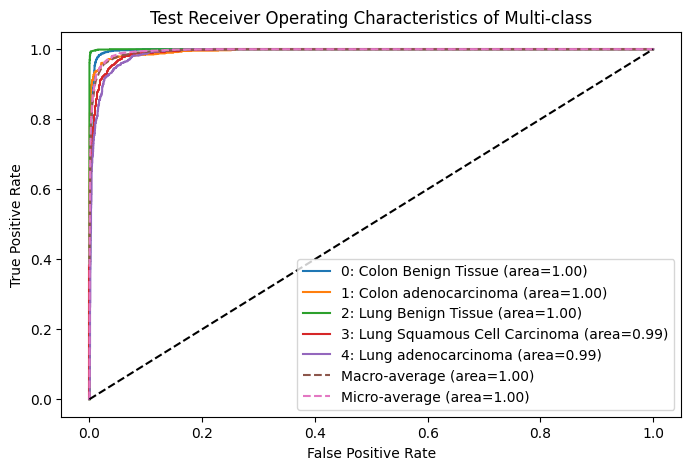

In [45]:
auc_roc_graph(y_val, model.predict(X_val, verbose=0), "Validation")
auc_roc_graph(y_test, model.predict(X_test, verbose=0), "Test")